In [1]:
import numpy as np
from sklearn.utils import shuffle
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Model
from keras import layers
from keras import optimizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import time
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

mi = 0  # counter for model input layer indexing with multiple models

Using TensorFlow backend.


In [0]:
def load_data(add_empty=True):
    # Load data
    (x_train, y_train), (x_val, y_val) = mnist.load_data()

    # Normalize data
    x_train = x_train.astype('float32')
    x_val = x_val.astype('float32')
    x_train /= 255
    x_val /= 255

    # Flatten data for MLP/RNN
    x_train = x_train.reshape(60000, 784)
    x_val = x_val.reshape(10000, 784)

    if add_empty:
        # Add empty class examples
        x_empty = np.asarray([np.repeat(np.random.uniform(low=0, high=0), (784, )) for i in range(7000)])
        y_empty = np.ones((7000, ), dtype=int) * 10
        x_train = np.concatenate((x_train, x_empty[:6000]), axis=0)
        y_train = np.concatenate((y_train, y_empty[:6000]), axis=0)
        x_val = np.concatenate((x_val, x_empty[6000:]), axis=0)
        y_val = np.concatenate((y_val, y_empty[6000:]), axis=0)

    # Transform labels to one-hot
    y_train = to_categorical(y_train, 10 + add_empty)
    y_val = to_categorical(y_val, 10 + add_empty)

    # Shuffle data
    x_train, y_train = shuffle(x_train, y_train)
    x_val, y_val = shuffle(x_val, y_val)

    print(x_train.shape[0], 'train samples')
    print(x_val.shape[0], 'validation samples')
    time.sleep(0.5)
    
    return x_train, y_train, x_val, y_val


def get_model(mi=0, n_classes=10, seq_len=5, t_factor=None, noise_mean=0.0, noise_std=0.05):# Set hyperparameters
    """Defines, compiles and returns a model."""
    use_repeat = False     # repeats the input to turn it into a sequence. not used in current implementation.
    use_threshold = False  # applies a thresholding factor during test phase.  not used in current implementation.
    use_noise = False      # adds noise during test phase. not used in current implementation.
    n_hidden = 20

    def threshold(inputs, t_factor=None):
        """Waters down inputs during test phase to get them below activation threshold.
        If no t_factor passed, uses random uniform."""
        if t_factor is None:
            t_factor = K.random_uniform((seq_len, inputs.shape[-1]), minval=0, maxval=1)
        x_threshold = inputs * t_factor
        x = K.in_test_phase(x_threshold, inputs)
        return x

    def add_noise(inputs, mean, std):
        """Adds noise during test phase."""
        x_noise = inputs + K.relu(K.random_normal((seq_len, inputs.shape[-1]), mean=mean, stddev=std))
        x = K.in_test_phase(x_noise, inputs)
        return x

    # Define model
    inputs = layers.Input(shape=(seq_len, 784), name='input_' + str(mi))  # unique name to differentiate between multiple models
    x = inputs
    if use_repeat: x = layers.RepeatVector(seq_len, name='repeat')(x)
    if use_threshold: x = layers.Lambda(lambda x: threshold(x, t_factor=t_factor), name='threshold')(x)
    if use_noise: x = layers.Lambda(lambda x: add_noise(x, noise_mean, noise_std), name='noise')(x)
    x = layers.LSTM(n_hidden, activation='relu', unit_forget_bias=True, unroll=False, name='lstm')(x)
    outputs = layers.Dense(n_classes, activation='softmax', name='dense')(x)

    # Initialize model and optimizer
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = optimizers.adam(lr=3e-4, clipvalue=0.5)

    # Compile model
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer, 
        metrics=['accuracy']
    )
    model._make_predict_function()
    
    return model


def train_model(model, x_train, y_train, x_val, y_val, n_epochs=3, verbose=1):
    """Trains the model and returns training history."""
    batch_size = 128
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        verbose=verbose,
                        validation_data=(x_val, y_val))
    
    return history


def plot_history(history):
    """Plots the history of accuracy and loss."""
    # Plot accuracy
    plt.plot(history.history['acc'], label='training accuracy')
    plt.plot(history.history['val_acc'], label='validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [3]:
# Load data
x_train, y_train, x_val, y_val = load_data(add_empty=True)

66000 train samples
11000 validation samples


W0701 20:28:56.797188 140398705776512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0701 20:28:56.816501 140398705776512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0701 20:28:56.817573 140398705776512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0701 20:28:56.818831 140398705776512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0701 20:28:56.831228 140398705776512 deprecation_wra

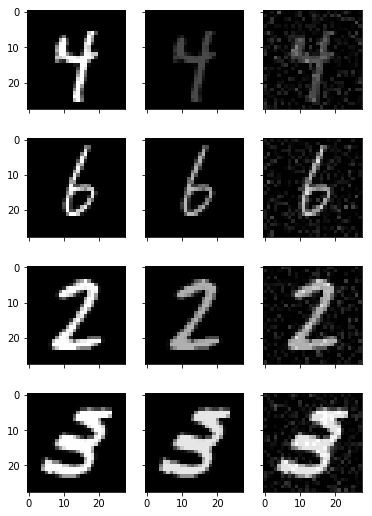

In [4]:
# Plot examples: original, random thresholding and with noise
noise_mean = 0.0   # mean for Gaussian noise
noise_std = 0.1   # standard devidation for Gaussian noise

n_images = 4
fig, axs = plt.subplots(n_images, 3, figsize=(6, n_images * 2.25), sharex=True, sharey=True)
for i in range(0, n_images):
    # Plot original
    x = np.reshape(x_train[i], (28, 28))
    axs[i, 0].imshow(x, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    # Plot sub-threshold
    x = x * np.random.random()
    axs[i, 1].imshow(x, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    # Plot with noise
    noise = K.eval(K.relu(K.random_normal((28, 28), mean=noise_mean, stddev=noise_std)))
    x = x + noise
    axs[i, 2].imshow(x, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

W0701 20:28:58.177613 140398705776512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_0 (InputLayer)         (None, 5, 784)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 20)                64400     
_________________________________________________________________
dense (Dense)                (None, 11)                231       
Total params: 64,631
Trainable params: 64,631
Non-trainable params: 0
_________________________________________________________________
None 




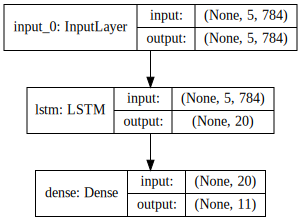

In [5]:
# Get model information
model = get_model(mi=mi, n_classes=y_train.shape[-1])
mi += 1  # to uniquely identify among multiple models
print(model.summary(), "\n\n")
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [6]:
# Train models
seq_len = 5   # LSTM sequence length
n_models = 5  # number of models, used for getting standard deviation of results

# Shape data into sequence
if x_train.ndim < 3: x_train = K.eval(K.repeat(K.variable(x_train), seq_len))
if x_val.ndim < 3: x_val = K.eval(K.repeat(K.variable(x_val), seq_len))

# Train models
models = []
for i in range(n_models):
    models.append(get_model(mi=mi, n_classes=y_train.shape[-1], seq_len=seq_len))
    mi += 1
    history = train_model(models[i], x_train, y_train, x_val, y_val, n_epochs=3, verbose=1)
    ##plot_history(history)
    print()

W0701 20:29:01.556429 140398705776512 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 66000 samples, validate on 11000 samples
Epoch 1/3
66000/66000 [==============================] - 11s 169us/step - loss: 0.7874 - acc: 0.8038 - val_loss: 0.4393 - val_acc: 0.9292
Epoch 2/3
66000/66000 [==============================] - 10s 157us/step - loss: 0.3850 - acc: 0.9380 - val_loss: 0.3237 - val_acc: 0.9454
Epoch 3/3
66000/66000 [==============================] - 10s 157us/step - loss: 0.2374 - acc: 0.9504 - val_loss: 0.1815 - val_acc: 0.9478

Train on 66000 samples, validate on 11000 samples
Epoch 1/3
66000/66000 [==============================] - 12s 186us/step - loss: 0.7883 - acc: 0.8197 - val_loss: 0.4393 - val_acc: 0.9351
Epoch 2/3
66000/66000 [==============================] - 11s 169us/step - loss: 0.3919 - acc: 0.9404 - val_loss: 0.3390 - val_acc: 0.9510
Epoch 3/3
66000/66000 [==============================] - 11s 169us/step - loss: 0.2844 - acc: 0.9532 - val_loss: 0.2326 - val_acc: 0.9565

Train on 66000 samples, validate on 11000 samples
Epoch 1/3
66000/6600

Running over 5 models...


100%|██████████| 7/7 [08:24<00:00, 73.91s/it]


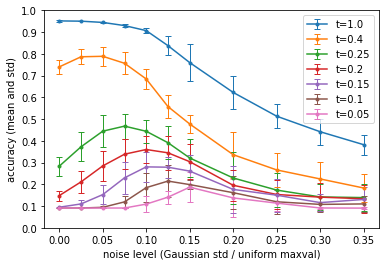

In [7]:
# Run grid search over thresholding and noise parameters.
# Use uniform or Gaussian noise by commenting out line 19/20.
t_factors = [1.0, 0.4, 0.25, 0.2, 0.15, 0.1, 0.05]
noise_mean = 0  # only used for Gaussian noise
noise_lvl = [0.0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35]  # std for Gaussian noise, maxval for uniform noise
print("Running over %d models..." % len(models))
time.sleep(0.5)

grid_results = []

# Loop overe thresholding factors
for t in tqdm(t_factors, leave=True):
    results = []
    # Loop over noise levels
    for ns_lvl in noise_lvl:
        accs = []
        # Loop over iterations to get mean and standard devation of results
        for m in models:
            ##noise = K.eval(K.relu(K.random_normal((1, seq_len, 784), mean=noise_mean, stddev=ns_lvl)))
            noise = K.eval(K.random_uniform((1, seq_len, 784), minval=0.0, maxval=ns_lvl))
            x = np.clip(x_val * t + noise, 0., 1.)  # clip values to not exceed 1.0
            pred = m.predict(x)
            accs.append(np.sum(np.argmax(y_val, axis=1) == np.argmax(pred, axis=1)) / y_val.shape[0])
        results.append((np.mean(accs), np.std(accs)))
    grid_results.append(results)

for i in range(len(t_factors)):
    plt.errorbar(noise_lvl, [x[0] for x in grid_results[i]], yerr=[x[1] for x in grid_results[i]],
                 marker='.', capsize=3, elinewidth=1, markeredgewidth=1)
plt.legend(['t=' + str(t) for t in t_factors])
plt.xlabel("noise level (Gaussian std / uniform maxval)")
plt.ylabel("accuracy (mean and std)")
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()

100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


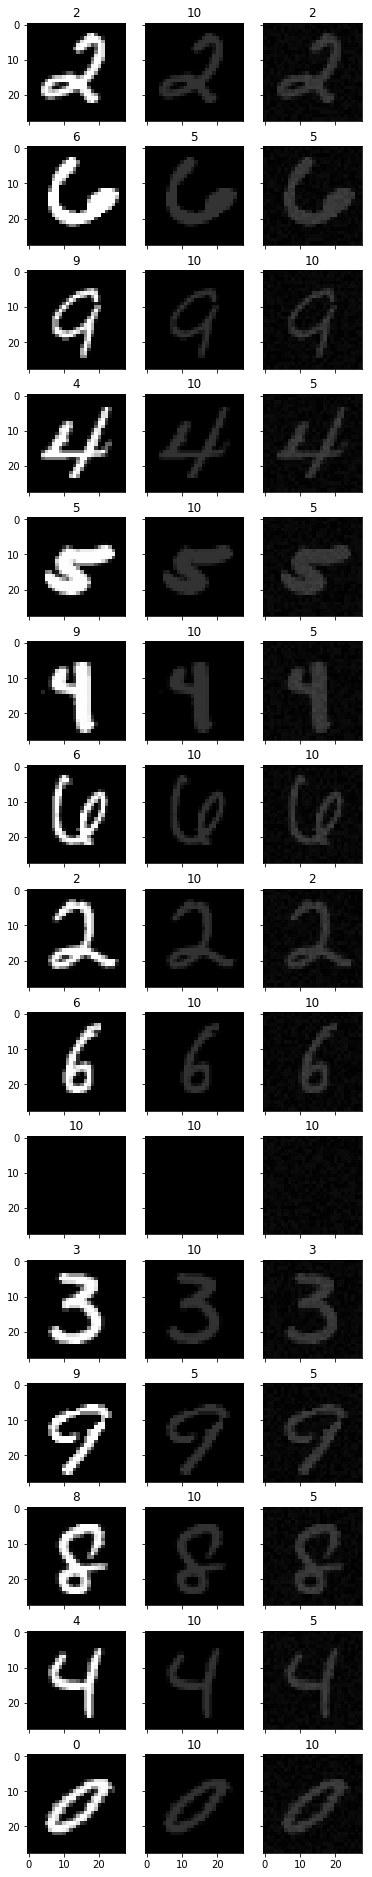

In [8]:
# Show examples of thresholding and noise effects on performance by predicting on random validation images
t_factor = 0.20
noise_mean = 0.0   # mean for Gaussian noise
noise_lvl = 0.05   # std for Gaussian noise, maxval for uniform noise
n_images = 15

# Plot original, sub-threshold and with noise
ix = np.random.choice(range(y_val.shape[0]), size=(n_images, ), replace=False)
fig, axs = plt.subplots(n_images, 3, figsize=(6, n_images * 2.25), sharex=True, sharey=True)
for i in trange(0, n_images, leave=True):
    
    # Plot original
    x = x_val[ix[i]:ix[i]+1]
    pred = np.argmax(models[0].predict(x))
    axs[i, 0].imshow(x[:, 0, :].flatten().reshape((28, 28)), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    axs[i, 0].set_title(str(pred))
    
    # Plot sub-threshold
    x = x * t_factor
    pred = np.argmax(models[0].predict(x))
    axs[i, 1].imshow(x[:, 0, :].flatten().reshape((28, 28)), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    axs[i, 1].set_title(str(pred))
    
    # Plot with noise
    ##noise = K.eval(K.relu(K.random_normal((1, seq_len, 784), mean=noise_mean, stddev=noise_lvl)))
    noise = K.eval(K.random_uniform((1, seq_len, 784), minval=0.0, maxval=noise_lvl))
    x = x + noise
    pred = np.argmax(models[0].predict(x))
    axs[i, 2].imshow(x[:, 0, :].flatten().reshape((28, 28)), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    axs[i, 2].set_title(str(pred))

plt.show()

66000 train samples
11000 validation samples


100%|██████████| 4/4 [11:37<00:00, 172.80s/it]


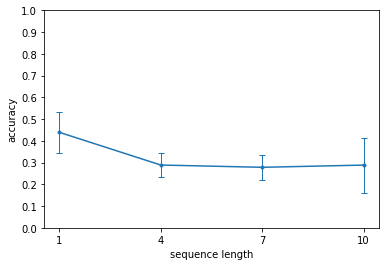

In [9]:
# Run over different sequence lengths (trains new model at each step)
# TODO: Possible memory leak observed.
x_train, y_train, x_val, y_val = load_data(add_empty=True)

# Define hyperparameters
seq_lengths = list(range(1, 11, 3))
t_factor = 0.15
ns_lvl = 0.075
n_iter = 5

results = []

for seq_len in tqdm(seq_lengths, leave=True):
    # Shape data into sequence
    x_t = K.eval(K.repeat(K.variable(x_train), seq_len))
    x_v = K.eval(K.repeat(K.variable(x_val), seq_len))
    
    accs = []
    
    # Loop over iterations to get mean and standard deviation of results
    for i in range(n_iter):
        # Train model
        K.clear_session()
        model = get_model(n_classes=y_train.shape[-1], seq_len=seq_len)
        history = train_model(model, x_t, y_train, x_v, y_val, n_epochs=3, verbose=0)
        ##plot_history(history)
        # Evaluate with thresholding and noise
        noise = K.eval(K.random_uniform((1, seq_len, 784), minval=0.0, maxval=ns_lvl))
        x = np.clip(x_v * t_factor + noise, 0., 1.)
        pred = model.predict(x)
        accs.append(np.sum(np.argmax(y_val, axis=1) == np.argmax(pred, axis=1)) / y_val.shape[0])
        del history, noise, x, pred
        K.clear_session()
    results.append((np.mean(accs), np.std(accs)))

plt.errorbar(seq_lengths, [x[0] for x in results], yerr=[x[1] for x in results],
             marker='.', capsize=3, elinewidth=1, markeredgewidth=1)
plt.xlabel("sequence length")
plt.ylabel("accuracy")
plt.xticks(seq_lengths)
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()